In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PBA_Fetcher import PBA_Fetcher
from wordcloud import WordCloud, ImageColorGenerator
from sqlalchemy import create_engine
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from PIL import Image

In [2]:
fetcher = PBA_Fetcher()

In [13]:
fetcher.get_avg_player()

,year,conference,player_name,team_name,pos,j_number,height,weight,GP,MIN,...,APG,STL,BLK,oREB,dREB,REB,PF,TOV,+/-,PTS
0,2017,GOV,L. Henton,ALA,SF,0.0,78.0,206.0,11,41.81,...,2.36,1.64,2.09,3.09,8.64,11.73,1.82,3.55,-4.45,28.09
1,2017,GOV,C. Abueva,ALA,PF,0.0,73.0,0.0,8,28.19,...,2.25,1.25,1.00,3.63,7.00,10.63,2.38,3.00,-0.50,15.00
2,2017,GOV,J. Casio,ALA,G,0.0,70.0,0.0,11,23.81,...,3.64,0.91,0.18,0.36,2.73,3.09,2.27,1.55,-1.00,10.27
3,2017,GOV,C. Banchero,ALA,G,22.0,74.0,0.0,10,23.40,...,3.10,0.90,0.20,1.40,2.40,3.80,2.50,2.30,-7.90,9.30
4,2017,GOV,V. Manuel,ALA,F,0.0,76.0,227.0,8,16.89,...,0.25,0.38,0.25,1.13,3.63,4.75,1.63,0.75,-3.38,8.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,2020,PH,R. Escoto,SMB,C,0.0,78.0,185.0,1,11.52,...,0.00,0.00,0.00,3.00,2.00,5.00,2.00,2.00,-8.00,3.00
1418,2020,PH,P. Zamar,SMB,G,0.0,0.0,215.0,1,4.52,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.00,3.00
1419,2020,PH,R. Gamalinda,SMB,G,0.0,76.0,0.0,1,5.57,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,-6.00,0.00
1420,2020,PH,V. Pessumal,SMB,G,0.0,74.0,215.0,1,9.65,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-3.00,0.00


In [14]:
fetcher.get_avg_total_player()

,year,conference,player_name,team_name,pos,j_number,height,weight,GP_avg,MIN_avg,...,APG_total,STL_total,BLK_total,oREB_total,dREB_total,REB_total,PF_total,TOV_total,+/-_total,PTS_total
0,2017,GOV,L. Henton,ALA,SF,0.0,78.0,206.0,11,41.81,...,26,18,23,34,95,129,20,39,-49,309
1,2017,GOV,C. Abueva,ALA,PF,0.0,73.0,0.0,8,28.19,...,18,10,8,29,56,85,19,24,-4,120
2,2017,GOV,J. Casio,ALA,G,0.0,70.0,0.0,11,23.81,...,40,10,2,4,30,34,25,17,-11,113
3,2017,GOV,C. Banchero,ALA,G,22.0,74.0,0.0,10,23.40,...,31,9,2,14,24,38,25,23,-79,93
4,2017,GOV,V. Manuel,ALA,F,0.0,76.0,227.0,8,16.89,...,2,3,2,9,29,38,13,6,-27,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,2020,PH,R. Escoto,SMB,C,0.0,78.0,185.0,1,11.52,...,0,0,0,3,2,5,2,2,-8,3
1418,2020,PH,P. Zamar,SMB,G,0.0,0.0,215.0,1,4.52,...,0,0,0,0,0,0,0,0,-4,3
1419,2020,PH,R. Gamalinda,SMB,G,0.0,76.0,0.0,1,5.57,...,0,1,0,0,0,0,0,1,-6,0
1420,2020,PH,V. Pessumal,SMB,G,0.0,74.0,215.0,1,9.65,...,0,0,0,0,0,0,0,0,-3,0


In [15]:
fetcher.get_all()

,year,conference,player_name,team_name,pos,j_number,height,weight,ply_GP_avg,ply_MIN_avg,...,tm_TO_total,tm_PTO_total,tm_PF_total,tm_FBm_total,tm_FBa_total,tm_FBm%_total,tm_bPTS_total,tm_PTS_total,tm_W_total,tm_L_total
0,2017,GOV,L. Henton,ALA,SF,0.0,78.0,206.0,11,41.81,...,15.64,17.64,22.27,7.18,8.18,11.91,36.73,94.0,3.0,8.0
1,2017,GOV,C. Abueva,ALA,PF,0.0,73.0,0.0,8,28.19,...,15.64,17.64,22.27,7.18,8.18,11.91,36.73,94.0,3.0,8.0
2,2017,GOV,J. Casio,ALA,G,0.0,70.0,0.0,11,23.81,...,15.64,17.64,22.27,7.18,8.18,11.91,36.73,94.0,3.0,8.0
3,2017,GOV,C. Banchero,ALA,G,22.0,74.0,0.0,10,23.40,...,15.64,17.64,22.27,7.18,8.18,11.91,36.73,94.0,3.0,8.0
4,2017,GOV,V. Manuel,ALA,F,0.0,76.0,227.0,8,16.89,...,15.64,17.64,22.27,7.18,8.18,11.91,36.73,94.0,3.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,2020,PH,R. Escoto,SMB,C,0.0,78.0,185.0,1,11.52,...,19.00,21.00,26.00,6.00,6.00,13.00,16.00,94.0,1.0,0.0
1418,2020,PH,P. Zamar,SMB,G,0.0,0.0,215.0,1,4.52,...,19.00,21.00,26.00,6.00,6.00,13.00,16.00,94.0,1.0,0.0
1419,2020,PH,R. Gamalinda,SMB,G,0.0,76.0,0.0,1,5.57,...,19.00,21.00,26.00,6.00,6.00,13.00,16.00,94.0,1.0,0.0
1420,2020,PH,V. Pessumal,SMB,G,0.0,74.0,215.0,1,9.65,...,19.00,21.00,26.00,6.00,6.00,13.00,16.00,94.0,1.0,0.0


In [96]:
chkcol = sum([1 if x else 0 for x in get_teamstat_with_name(df_team_avg_stat).isnull().any()])
print('There are {} columns with NaN'.format(chkcol))


There are 0 columns with NaN


# Word Cloud Player Frequency

In [15]:
def display_wc_player_freq():
    """Show playername Wordcloud based on minutes"""
    # Get player frequency
    engine = create_engine('sqlite:///pba.db')
    with engine.connect() as conn:
        df_player_total_mins = pd.read_sql("""SELECT p.player_name, ts.`MIN`
                                                FROM player p
                                                INNER JOIN total_stat ts
                                                ON p.`index` = ts.player_id
                                            """,
                                           con=conn)
    engine.dispose()
    df_player_total_mins.MIN = (df_player_total_mins.MIN
                                .apply(lambda x: round(x)))
    df_player_total_mins['last_name'] = (df_player_total_mins.player_name
                                     .apply(lambda x: x.split('. ')[1]))
    # Sum total frequency per conference
    player_freq = (df_player_total_mins.groupby('last_name')
               .sum().squeeze().to_dict())
    pba_mask = np.array(Image.open('pba_logo_wc.png'))
    # Word Cloud
    wc = WordCloud(mask=pba_mask, random_state=40, relative_scaling=0, 
                  background_color="white", regexp=r'\b[a-zA-Z]+?\b',
                   repeat=False)

    wc.generate_from_frequencies(player_freq)

    image_colors = ImageColorGenerator(pba_mask)
    wc.recolor(color_func=image_colors)
    plt.figure(figsize=(20, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off');

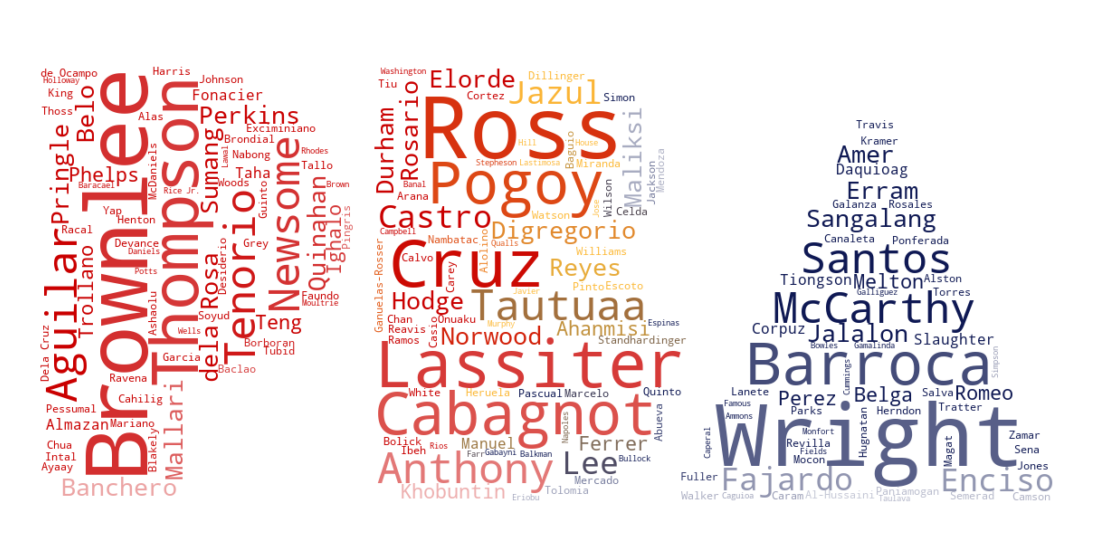

In [13]:
display_wc_player_freq()

# Hierarchical Clustering Team

In [16]:
def plot_variance(decomposition, title, ax, xlabel='SV'):
    """Plot latend"""
    var_exp = decomposition.explained_variance_ratio_
    ax.plot(range(1, len(var_exp)+1), var_exp, 'o-', label='individual')

    ax.set_xlim(0, len(var_exp)+1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('variance explained')
    ax = ax.twinx()
    ax.plot(range(1, len(var_exp)+1),
            var_exp.cumsum(), 'ro-', label='cumulative')
    ax.set_ylabel('cumulative variance explained')
    ax.set_xlim(1)
    ax.axhline(0.9, c='g', linestyle='dashed')
    ax.set_title(title)


def plot_dendrogram(Z, ax):
    """Accepts output of linkage and plot dendogram"""
    res = dendrogram(Z, ax=ax, truncate_mode='level', p=5)
    ax.set_ylabel(r'$\Delta$')
    return ax


def plot_cluster(x, z, t, ax):
    """Accept linkage and plot clusters"""
    y_predict_ng = fcluster(z, t=t, criterion='distance')
    ax.scatter(x[:, 0], x[:, 1], c=y_predict_ng)
    ax.set_title(f'k={max(y_predict_ng)}, t={np.around(t, 3)}')
    return ax


def plot_svd(columns, weights, ax):
    """Plot SVD"""
    for col, vec in zip(columns, weights):
        ax.arrow(0, 0, vec[0], vec[1], width=0.01, ec='none', fc='r')
        ax.text(vec[0], vec[1], col, ha='center', color='r', fontsize=18)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('SV1')
    ax.set_ylabel('SV2')
    return ax

## Average Team Statistics

In [18]:
df_avg_team = get_teamstat_with_name(df_team_avg_stat)
df_avg_team = df_avg_team.loc[df_avg_team.year.astype(int) < 2020]
feature_raw = df_avg_team.drop(['year', 'conference', 'team_name'], axis=1)
feature = StandardScaler().fit_transform(feature_raw)

### Explore Dimensionality Reduction

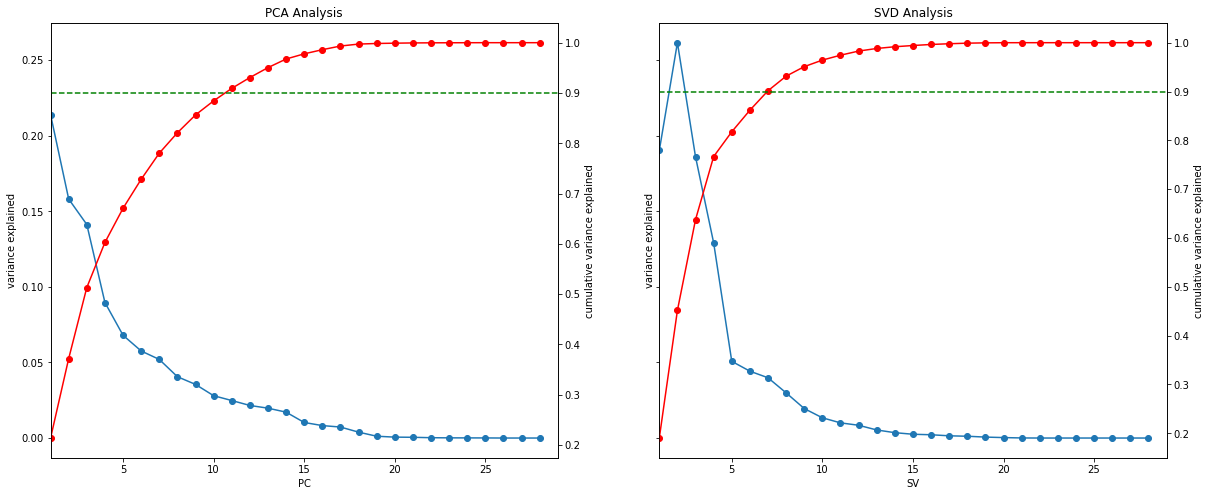

In [210]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
plot_variance(PCA(feature.shape[1] - 1).fit(feature),
              'PCA Analysis', ax1, xlabel='PC')
plot_variance(TruncatedSVD(feature_raw.shape[1] - 1).fit(feature_raw),
              'SVD Analysis', ax2, xlabel='SV')

In this report, we have performed a dimensional reduction analysis for the team statistics to reduce the number of dimensions. Comparing two-dimensionality reduction methods, PCA and Truncated SVD, we determined using Truncated SVD is better than using PCA since we achieved a 90% cumulative explained variance with just seven components where using PCA needed eleven components.

In [237]:
svd_avg = TruncatedSVD(2).fit(feature_raw)
feature_new = svd_avg.transform(feature_raw)

### Ward's Method

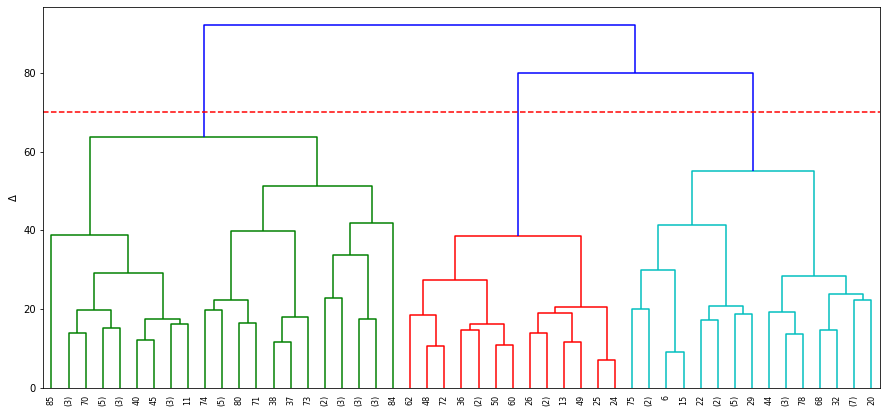

In [226]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_ward = linkage(feature_raw, method='ward', optimal_ordering=True)
ax = plot_dendrogram(Z_ward, ax)
ax.axhline(70, c='r', linestyle='dashed');

### Single Linkage Method

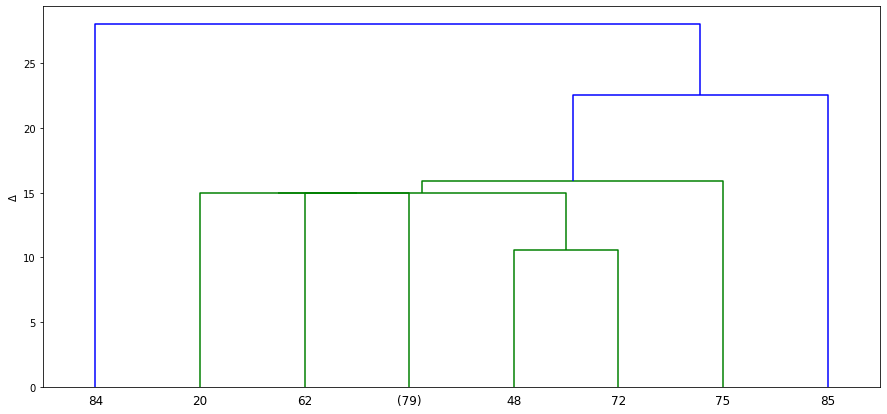

In [220]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_single = linkage(feature_raw, method='single', optimal_ordering=True)
ax = plot_dendrogram(Z_single, ax)

### Complete Linkage Method

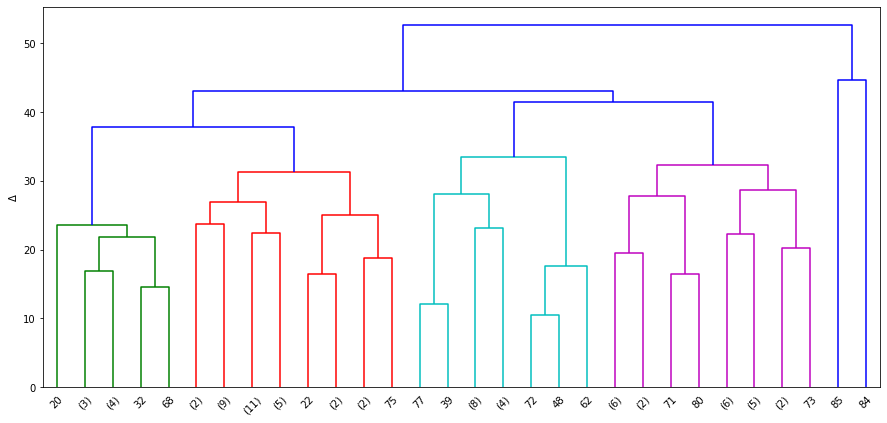

In [221]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_complete = linkage(feature_raw, method='complete', optimal_ordering=True)
ax = plot_dendrogram(Z_complete, ax)

### Average Linkage Method

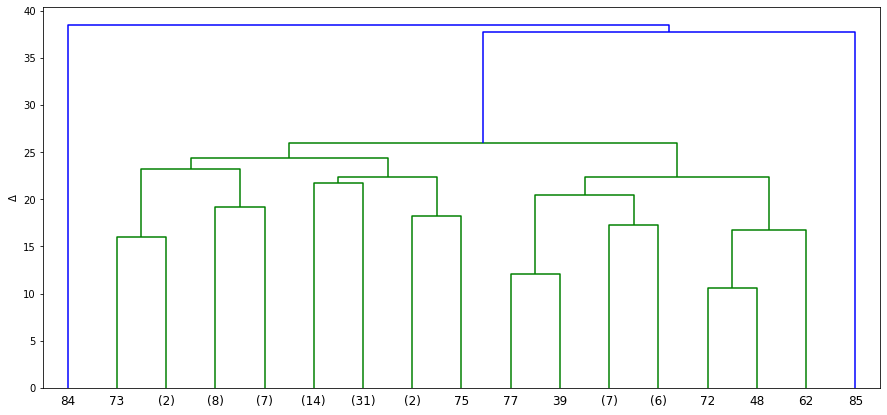

In [222]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_average = linkage(feature_raw, method='average', optimal_ordering=True)
ax = plot_dendrogram(Z_average, ax)

### Result

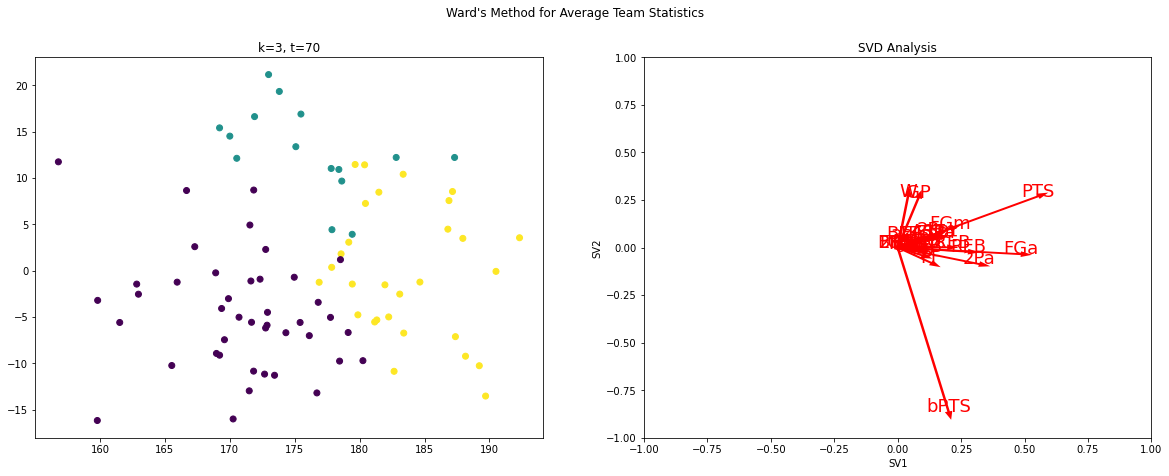

In [274]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1 = plot_cluster(feature_new, Z_ward, 70, ax1)
ax2= plot_svd(feature_raw.columns, svd_avg.components_.T, ax2)
ax2.set_title('SVD Analysis')

plt.suptitle("Ward's Method for Average Team Statistics");

We have examined the performance of each Agglomerative clustering method using dendrograms. From the results we have gathered, we infer that using Ward's method is the best for this scenario. Unlike the other methods, Ward's method formed clusters that are far from each other, and the number of each data point within the cluster is balanced. Three groups yield the longest distance from other clusters with a threshold of 70.

Observing the SV1 and SV2 of the decomposed dataset, we can find that the most dominant feature in SV2 is bPTS while PTS is the most dominant feature in SV1. As the two most dominant feature in the dataset are orthogonal to one another, we infer that there is no correlation between PTS and bPTS. Based on the magnitude of the bPTS, we can cluster the dataset with players with low bPTS.

## Total Team Statistics

In [284]:
df_tot_team = get_teamstat_with_name(df_team_tot_stat)
df_tot_team = df_tot_team.loc[df_tot_team.year.astype(int) < 2020]
features_raw = df_tot_team.drop(['year', 'conference', 'team_name'], axis=1)
feature = StandardScaler().fit_transform(feature_raw)

### Explore Dimensionality Reduction

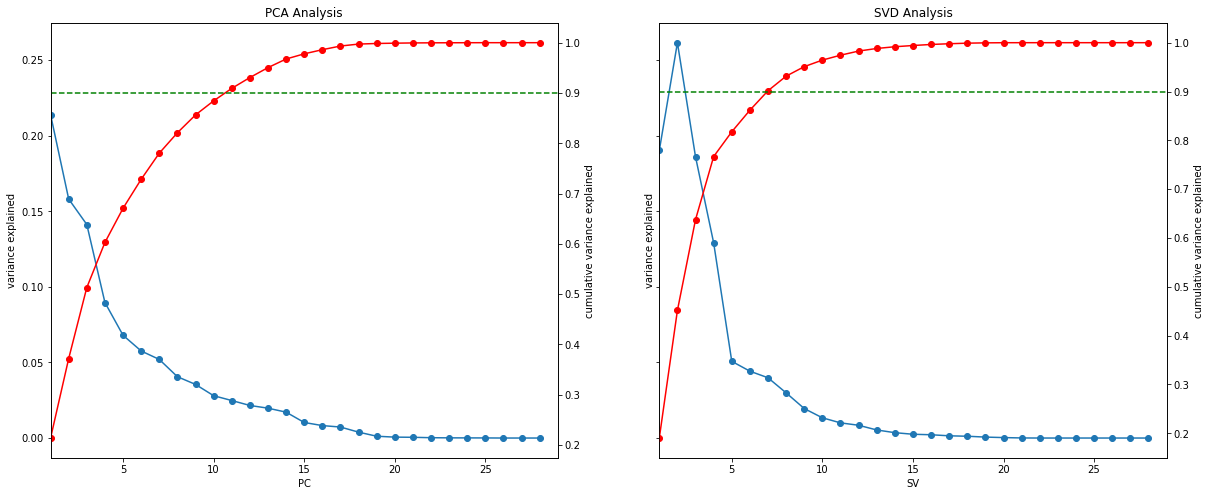

In [285]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
plot_variance(PCA(feature.shape[1] - 1).fit(feature),
              'PCA Analysis', ax1, xlabel='PC')
plot_variance(TruncatedSVD(feature_raw.shape[1] - 1).fit(feature_raw),
              'SVD Analysis', ax2, xlabel='SV')

In this report, we have performed a dimensional reduction analysis for the team statistics to reduce the number of dimensions. Comparing two-dimensionality reduction methods, PCA and Truncated SVD, we determined using Truncated SVD is better than using PCA since we achieved a 90% cumulative explained variance with just seven components where using PCA needed eleven components.

In [286]:
svd_avg = TruncatedSVD(2).fit(feature_raw)
feature_new = svd_avg.transform(feature_raw)

### Ward's Method

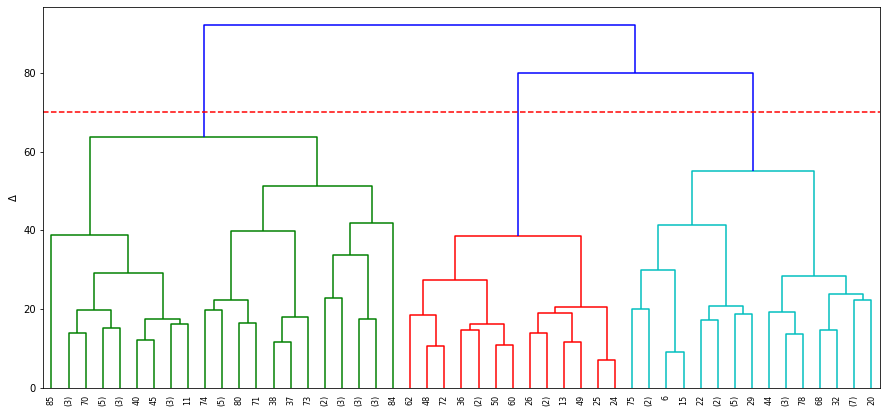

In [287]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_ward = linkage(feature_raw, method='ward', optimal_ordering=True)
ax = plot_dendrogram(Z_ward, ax)
ax.axhline(70, c='r', linestyle='dashed');

### Single Linkage Method

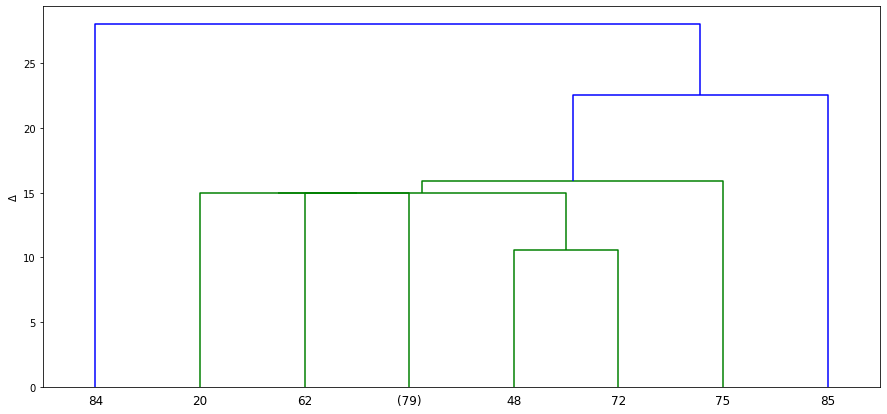

In [280]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_single = linkage(feature_raw, method='single', optimal_ordering=True)
ax = plot_dendrogram(Z_single, ax)

### Complete Linkage Method

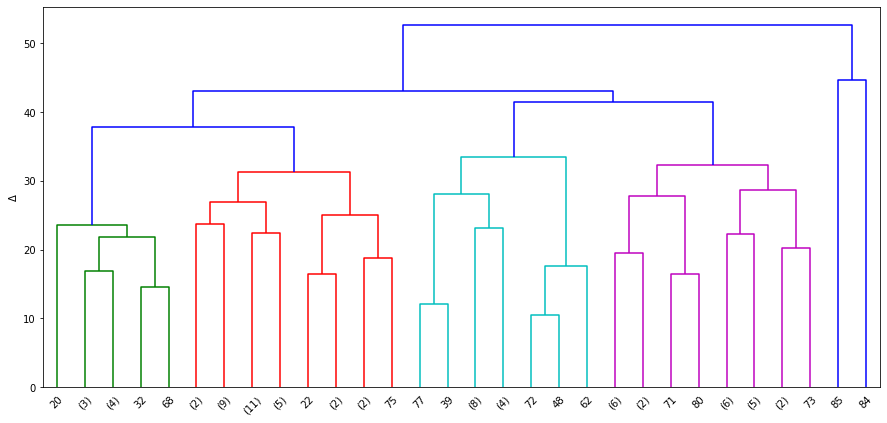

In [281]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_complete = linkage(feature_raw, method='complete', optimal_ordering=True)
ax = plot_dendrogram(Z_complete, ax)

### Average Linkage Method

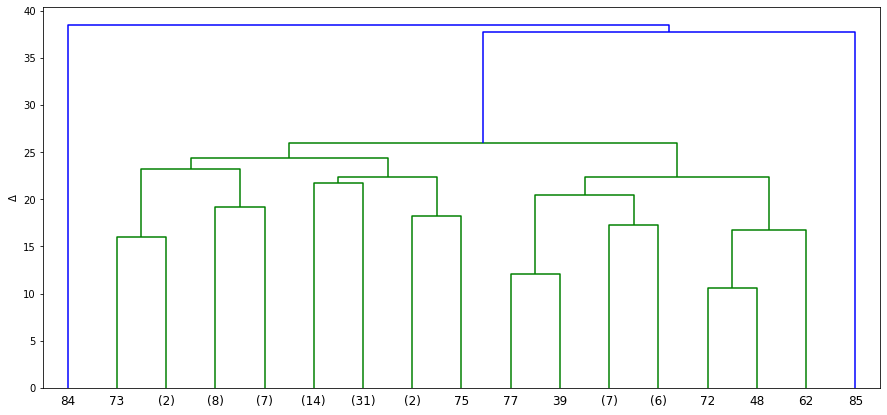

In [282]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_average = linkage(feature_raw, method='average', optimal_ordering=True)
ax = plot_dendrogram(Z_average, ax)

### Result

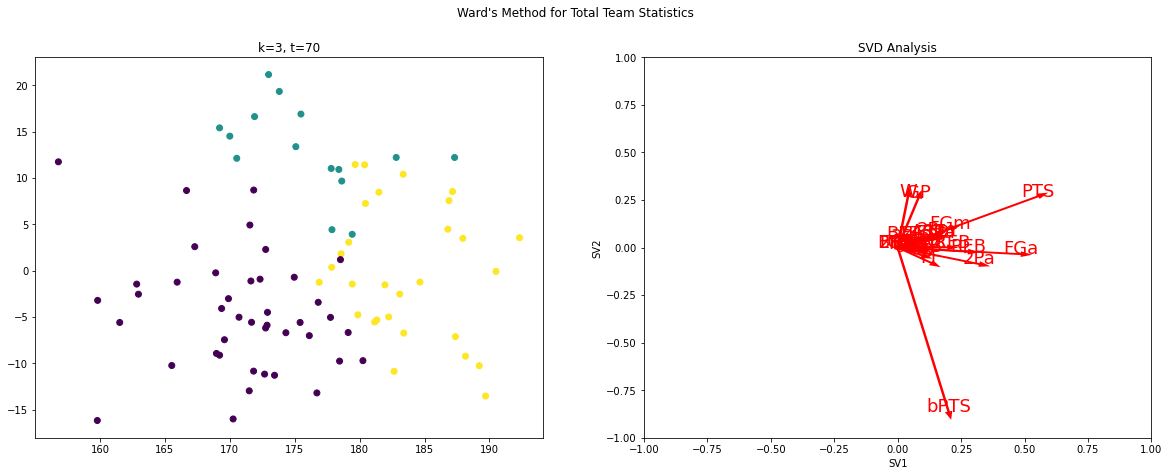

In [288]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1 = plot_cluster(feature_new, Z_ward, 70, ax1)
ax2= plot_svd(feature_raw.columns, svd_avg.components_.T, ax2)
ax2.set_title('SVD Analysis')

plt.suptitle("Ward's Method for Total Team Statistics");

We have examined the performance of each Agglomerative clustering method using dendrograms. From the results we have gathered, we infer that using Ward's method is the best for this scenario. Unlike the other methods, Ward's method formed clusters that are far from each other, and the number of each data point within the cluster is balanced. Three groups yield the longest distance from other clusters with a threshold of 70.

Observing the SV1 and SV2 of the decomposed dataset, we can find that the most dominant feature in SV2 is bPTS while PTS is the most dominant feature in SV1. As the two most dominant feature in the dataset are orthogonal to one another, we infer that there is no correlation between PTS and bPTS. Based on the magnitude of the bPTS, we can cluster the dataset with players with low bPTS.

## Average + Total Team Statistics

In [289]:
get

,index,team_id,hist_id,GP,3Pm,3Pa,3P%,2Pm,2Pa,2P%,...,TO,PTO,PF,FBm,FBa,FBm%,bPTS,PTS,W,L
0,0,3,0,23,7.65,22.48,0.34,30.35,60.70,0.50,...,17.30,17.09,19.17,5.39,6.00,9.52,29.00,99.52,16,7
1,1,5,0,23,9.96,27.87,0.36,25.74,55.00,0.47,...,15.43,15.30,21.04,6.43,7.13,11.83,25.87,94.83,16,7
2,2,11,0,17,10.47,33.59,0.31,28.35,55.06,0.51,...,17.12,17.12,25.65,7.35,8.24,13.41,27.94,105.35,10,7
3,3,9,0,13,12.23,36.46,0.34,25.54,51.46,0.50,...,17.69,18.62,23.54,6.46,7.08,11.54,45.08,101.85,8,5
4,4,4,0,15,7.47,23.80,0.31,29.73,61.13,0.49,...,15.67,21.20,23.20,7.07,7.47,13.27,42.60,96.07,8,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,81,2,6,11,9.09,28.64,0.32,25.36,55.00,0.46,...,16.55,18.45,25.27,7.64,8.27,14.00,45.00,94.36,4,7
82,82,5,6,11,8.55,29.73,0.29,25.09,55.00,0.46,...,13.55,14.73,23.27,5.00,5.18,8.82,40.64,90.00,3,8
83,83,1,6,11,7.82,25.64,0.30,26.73,60.09,0.44,...,16.36,18.00,22.82,7.36,8.09,13.55,43.45,92.82,2,9
84,84,10,7,1,12.00,32.00,0.38,25.00,44.00,0.57,...,19.00,21.00,26.00,6.00,6.00,13.00,16.00,94.00,1,0


In [284]:
df_tot_team = get_teamstat_with_name(df_team_tot_stat)
df_tot_team = df_tot_team.loc[df_tot_team.year.astype(int) < 2020]
features_raw = df_tot_team.drop(['year', 'conference', 'team_name'], axis=1)
feature = StandardScaler().fit_transform(feature_raw)

### Explore Dimensionality Reduction

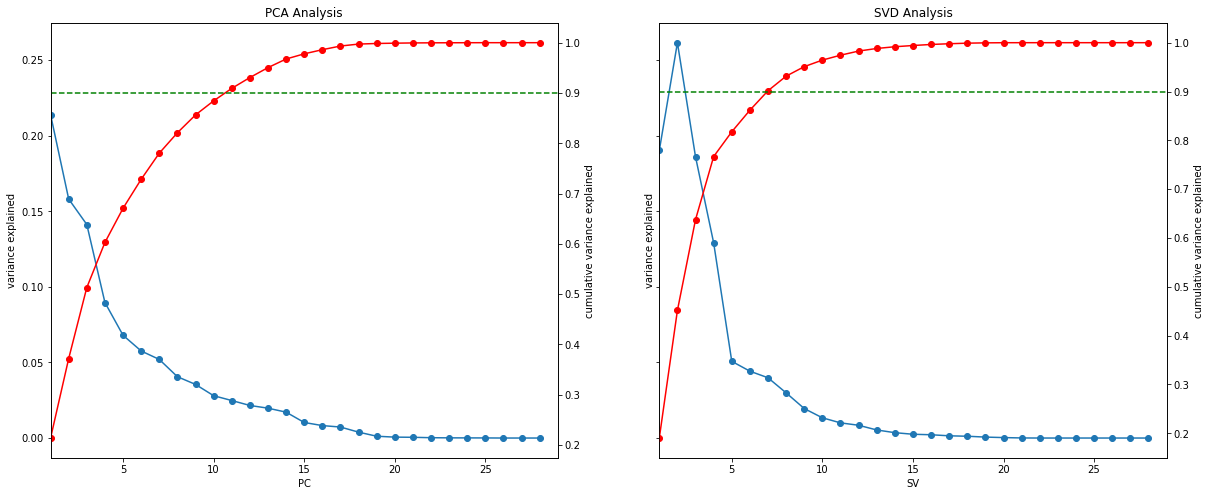

In [285]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
plot_variance(PCA(feature.shape[1] - 1).fit(feature),
              'PCA Analysis', ax1, xlabel='PC')
plot_variance(TruncatedSVD(feature_raw.shape[1] - 1).fit(feature_raw),
              'SVD Analysis', ax2, xlabel='SV')

In this report, we have performed a dimensional reduction analysis for the team statistics to reduce the number of dimensions. Comparing two-dimensionality reduction methods, PCA and Truncated SVD, we determined using Truncated SVD is better than using PCA since we achieved a 90% cumulative explained variance with just seven components where using PCA needed eleven components.

In [286]:
svd_avg = TruncatedSVD(2).fit(feature_raw)
feature_new = svd_avg.transform(feature_raw)

### Ward's Method

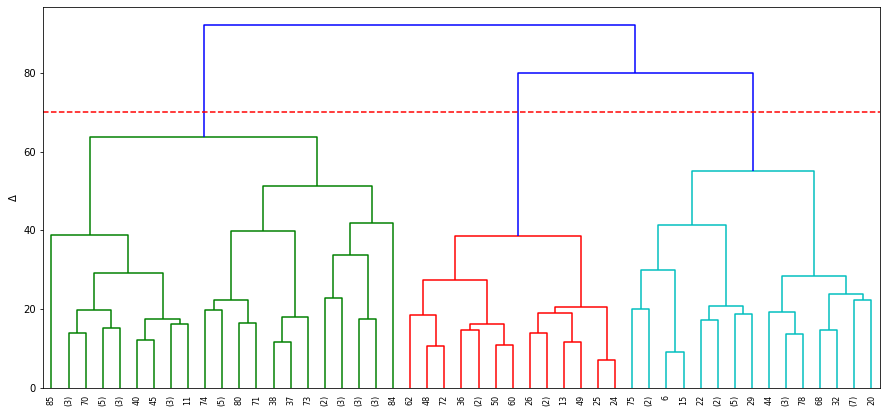

In [287]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_ward = linkage(feature_raw, method='ward', optimal_ordering=True)
ax = plot_dendrogram(Z_ward, ax)
ax.axhline(70, c='r', linestyle='dashed');

### Single Linkage Method

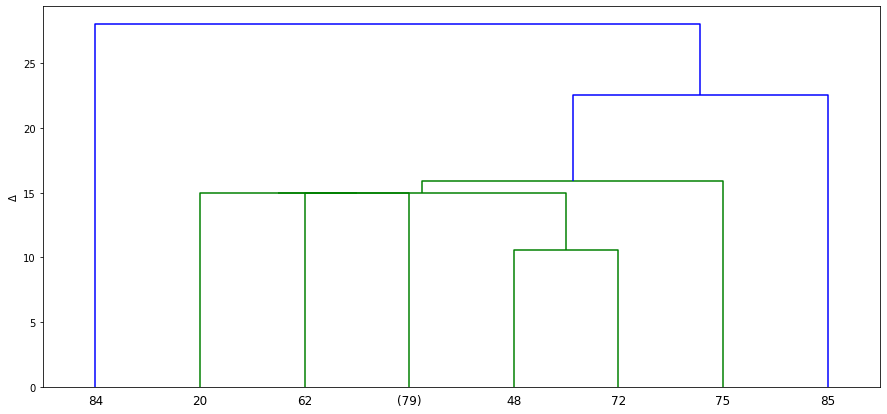

In [280]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_single = linkage(feature_raw, method='single', optimal_ordering=True)
ax = plot_dendrogram(Z_single, ax)

### Complete Linkage Method

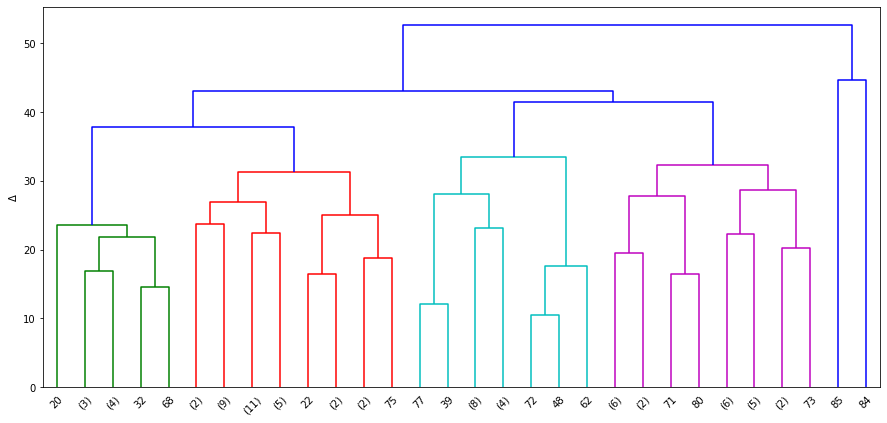

In [281]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_complete = linkage(feature_raw, method='complete', optimal_ordering=True)
ax = plot_dendrogram(Z_complete, ax)

### Average Linkage Method

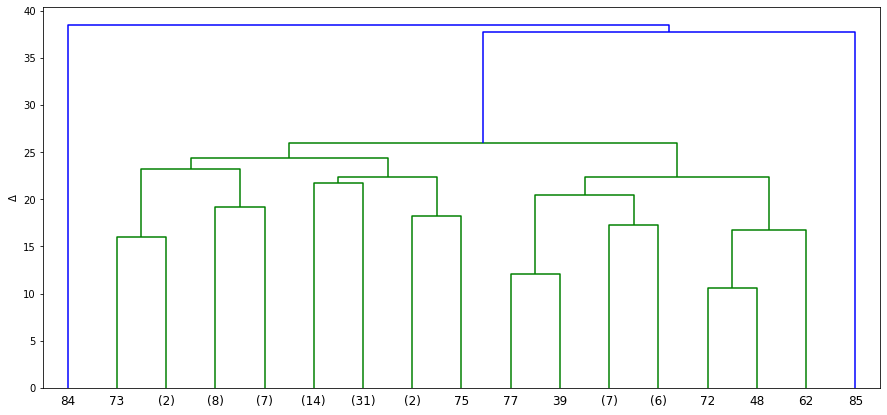

In [282]:
fig, ax = plt.subplots(figsize=(15, 7))
Z_average = linkage(feature_raw, method='average', optimal_ordering=True)
ax = plot_dendrogram(Z_average, ax)

### Result

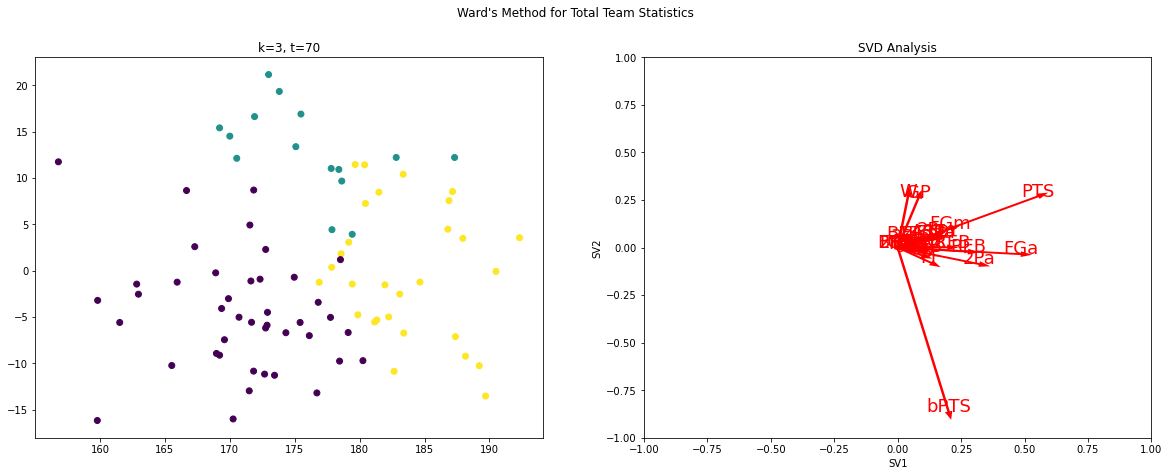

In [288]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1 = plot_cluster(feature_new, Z_ward, 70, ax1)
ax2= plot_svd(feature_raw.columns, svd_avg.components_.T, ax2)
ax2.set_title('SVD Analysis')

plt.suptitle("Ward's Method for Total Team Statistics");

We have examined the performance of each Agglomerative clustering method using dendrograms. From the results we have gathered, we infer that using Ward's method is the best for this scenario. Unlike the other methods, Ward's method formed clusters that are far from each other, and the number of each data point within the cluster is balanced. Three groups yield the longest distance from other clusters with a threshold of 70.

Observing the SV1 and SV2 of the decomposed dataset, we can find that the most dominant feature in SV2 is bPTS while PTS is the most dominant feature in SV1. As the two most dominant feature in the dataset are orthogonal to one another, we infer that there is no correlation between PTS and bPTS. Based on the magnitude of the bPTS, we can cluster the dataset with players with low bPTS.